In [1]:
%matplotlib inline

# Importing the data
The dataset can be downloaded at https://www.kaggle.com/datasets/athu1105/book-genre-prediction

In [2]:
import pandas as pd

# Read the data
df = pd.read_csv('../data/book_genre_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4657 entries, 0 to 4656
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    4657 non-null   int64 
 1   title    4657 non-null   object
 2   genre    4657 non-null   object
 3   summary  4657 non-null   object
dtypes: int64(1), object(3)
memory usage: 145.7+ KB


In [4]:
df.head()

,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


As we can see above, the dataset contains 4,657 entries, each consisting of a book title, corresponding summary, and the target genre.

We also want to check for any null entries in the dataset.

In [5]:
df.isnull().sum()

index      0
title      0
genre      0
summary    0
dtype: int64

We can thus see that there are no missing values in the dataset.

Since the `index` column doesn't describe the data in any meaningful way, we drop the entire column.

In [6]:
df.drop('index', inplace=True, axis=1)
df.head()

,title,genre,summary
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


# Data Exploration
The first thing we would like to know is the distribution of class labels, which among other things tells us how balanced the dataset is.

In [7]:
genre_counts = df['genre'].value_counts()

We will visualize this distribution in a histogram and a pie chart, for which we'll need `matplotlib` and `seaborn`.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

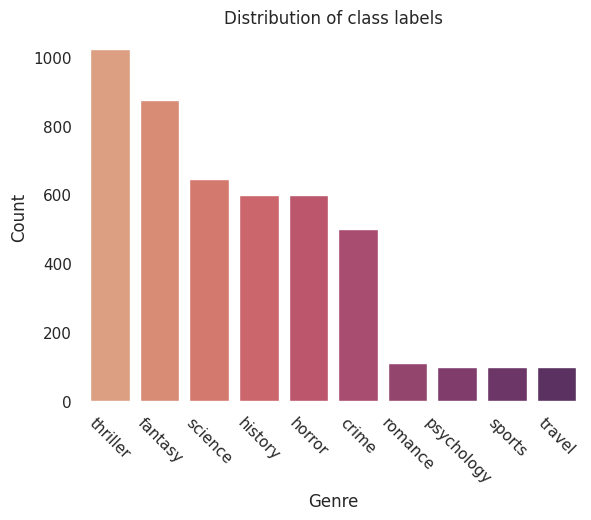

In [9]:
sns.barplot(
    x = genre_counts.index,
    y = genre_counts,
    palette = 'flare'
)

# Set plot title, axes decorations
plt.title("Distribution of class labels")
ax = plt.gca()
ax.set(xlabel='Genre', ylabel='Count')
ax.tick_params(axis='x', labelrotation=-45, labelsize=11)
sns.despine(bottom=True, left=True)

Text(0.5, 1.0, 'Distribution of class labels')

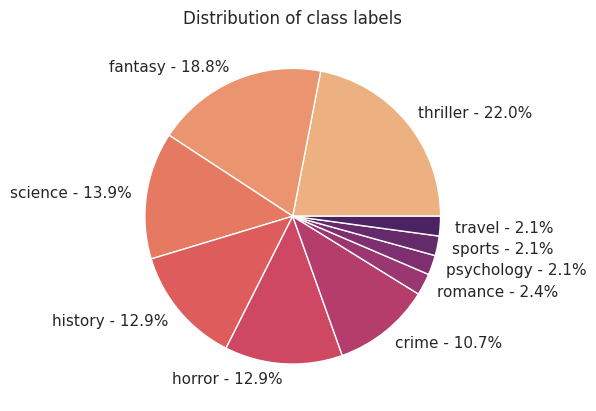

In [10]:
import numpy as np

# Get class distributions as percentages
percentages = 100 * genre_counts / genre_counts.sum()

# Define labels and colors for pie chart
pie_labels = [f"{x} - {y:.1f}%" for x,y in zip(genre_counts.index, percentages)]
pie_colors = plt.get_cmap('flare')(np.linspace(0,1,len(percentages)))

# Plot the pie chart
plt.pie(
    x = genre_counts,
    labels = pie_labels,
    colors = pie_colors
)
plt.title("Distribution of class labels")

From the bar plot and pie chart above, we can see that the class labels are quite imbalanced:
- **travel**, **sports**, **psychology**, and **romance** each make up about 2% of the total dataset, making them well balanced relative to each other but not the rest of the dataset.
- **thriller** and **fantasy** each make up a larger percentage of the data than any of the other genres.
- **science**, **history**, **horror**, and **crime** are all quite well balanced with each other.

# Cleaning up the data

In [11]:
from sklearn.base import TransformerMixin, BaseEstimator

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.loc[:,self.variables]

In [12]:
class LowercaseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_lower = X.apply(lambda x: x.lower())
        return X_lower

In [13]:
import re
import string

class RemovePunctuation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        punct_pattern = re.compile("[" + re.escape(string.punctuation) + "]")
        X_no_punct = X.apply(lambda x: re.sub(punct_pattern, '', x))
        return X_no_punct

In [14]:
class RemoveShortWords(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(lambda x: ' '.join([x for x in x.split() if len(x) > 3]))

In [15]:
class DropDataEntries(BaseEstimator, TransformerMixin):
    def __init__(self, ids):
        self.ids = ids
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        for i in self.ids:
            X_ = X_.drop(i)
        return X_

In [16]:
class DropNonTextEntries(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(lambda x: re.sub(r'^(?!.*[A-Za-z]).*', '', x))

In [17]:
import langdetect

class LangDetection(BaseEstimator, TransformerMixin):
    def __init__(self, lang='en'):
        self.lang = lang
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        X_['lang'] = X_.apply(lambda x: langdetect.detect(x))
        X_lang_only = X[X_['lang'] == self.lang]
        return X_lang_only

In [18]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

class RemoveStopwords(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords=stop_words):
        self.stopwords = stopwords
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_no_stopwords = X.apply(lambda x: ' '.join([w for w in x.split() if w not in self.stopwords]))
        return X_no_stopwords

[nltk_data] Downloading package stopwords to /home/mia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatizer):
        self.lemmatizer = lemmatizer
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        lemmatize_func = lambda x: ' '.join(
            [self.lemmatizer.lemmatize(w) for w in x.split()]
        )
        X_lemmatized = X.apply(lemmatize_func)
        return X_lemmatized

In [20]:
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer

nonsense_summaries_idx = [262, 338, 588, 834, 1574, 1772, 2410, 2485]
wnl = WordNetLemmatizer()

clean_text_pipeline = Pipeline([
    ('get_summary', FeatureSelector('summary')),
    #('drop_nonsense_summaries', DropDataEntries(nonsense_summaries_idx)),
    ('lowercase',    LowercaseTransformer()),
    ('remove_punctuation', RemovePunctuation()),
    ('drop_nonsense_summaries', DropDataEntries(nonsense_summaries_idx)), 
    ('drop_nontext_summaries', DropNonTextEntries()),
    ('detect_lang', LangDetection()),
    ('remove_stopwords', RemoveStopwords()),
    ('lemmatize', Lemmatizer(wnl)),
    ('remove_short_words', RemoveShortWords()),
])

In [21]:
clean_text_pipeline

Pipeline(steps=[('get_summary', FeatureSelector(variables='summary')),
                ('lowercase', LowercaseTransformer()),
                ('remove_punctuation', RemovePunctuation()),
                ('drop_nonsense_summaries',
                 DropDataEntries(ids=[262, 338, 588, 834, 1574, 1772, 2410,
                                      2485])),
                ('drop_nontext_summaries', DropNonTextEntries()),
                ('detect_lang', LangDetection()),
                ('remove_stopwords', RemoveStopwords()),
                ('lemmatize', Lemmatizer(lemmatizer=<WordNetLemmatizer>)),
                ('remove_short_words', RemoveShortWords())])

In [22]:
df['clean_text'] = clean_text_pipeline.fit_transform(df)

In [23]:
df = df.dropna(how='any', axis=0)

# Word cloud analysis

In [24]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(background_color='white', colormap='flare',
               max_font_size=75, random_state=42,)

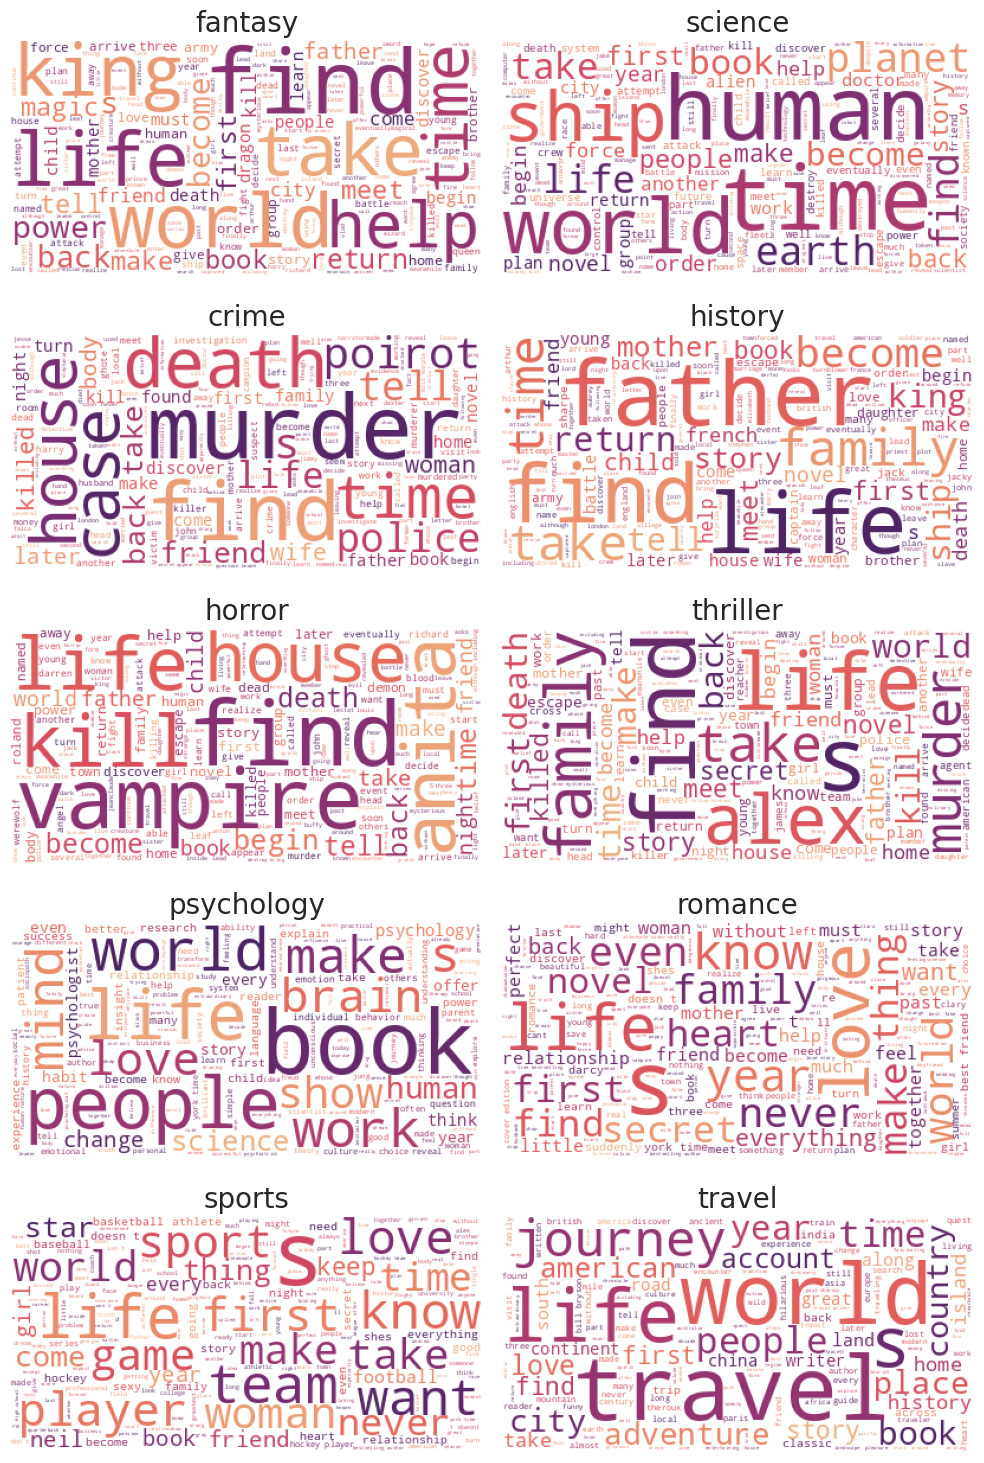

In [25]:
genre_values = df.genre.unique()

N_ROWS, N_COLS = 5, 2
fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(10,15))

row_index, col_index = 0, 0

for label in genre_values:
    text = ' '.join(df[df['genre']==label]['clean_text'])
    wc.generate(text)
    
    if col_index > N_COLS-1:
        row_index += 1
        col_index = 0
            
    ax[row_index][col_index].imshow(wc)
    ax[row_index][col_index].axis('off')
    ax[row_index][col_index].set_title(label, size=20)
    
    col_index += 1
    
plt.tight_layout()
plt.show()